Initializing PyImageJ

In [1]:
import imagej

# initialize ImageJ
ij = imagej.init('sc.fiji:fiji:2.14.0')
print(f"ImageJ version: {ij.getVersion()}")

ImageJ version: 2.14.0/1.54f


Open an image

Operating in headless mode - the original ImageJ will have limited functionality.
Operating in headless mode - the IJ class will not be fully functional.


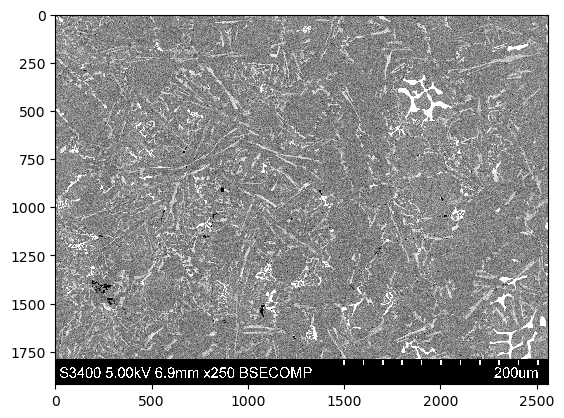

In [2]:
imp = ij.IJ.openImage("C:/Users/magfa/Documents/Prosjekt/Prosjektbilder/SEM Fe tilsetning og kjølerate/6ps/BSE_x250_m007.tif")
ij.py.show(imp, cmap='Grays_r')

#dataset = ij.io().open('C:/Users/magfa/Documents/Prosjekt/Prosjektbilder/SEM Fe tilsetning og kjølerate/6ps/BSE_x250_m007.tif')
#ij.py.show(dataset, cmap='Grays_r')

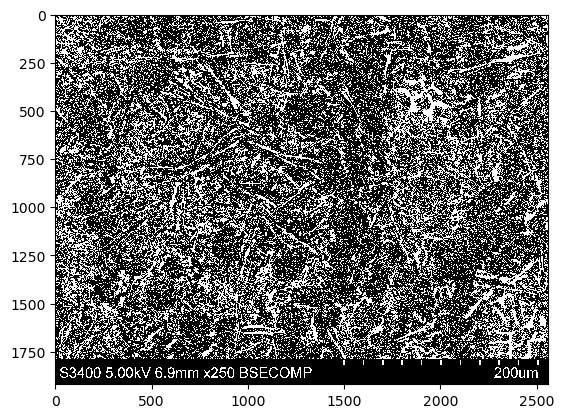

In [3]:
#imp.setAutoThreshold("Default dark no-reset")
#ij.Prefs.blackBackground = True
ij.IJ.run(imp, "Convert to Mask", "")
ij.py.show(imp, cmap='Grays_r')

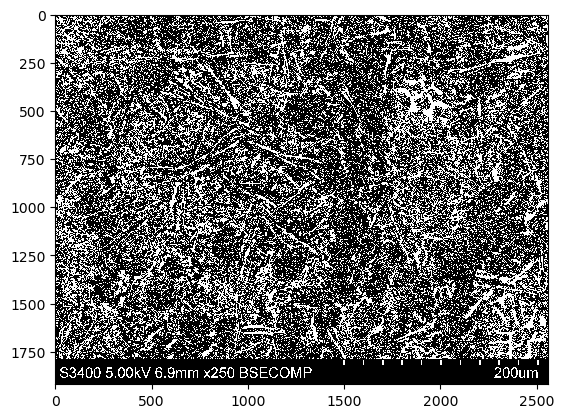

In [4]:
ij.IJ.run(imp, "Subtract Background...", "")
ij.py.show(imp, cmap='Grays_r')

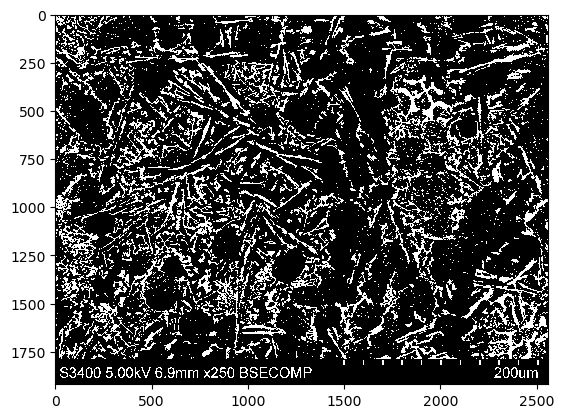

In [5]:
for i in range(100):
    ij.IJ.run(imp, "Despeckle", "")
ij.py.show(imp, cmap='Grays_r')

Following the PyImageJ Segmentation Tutorial in the following cells

In [6]:
import scyjava as sj

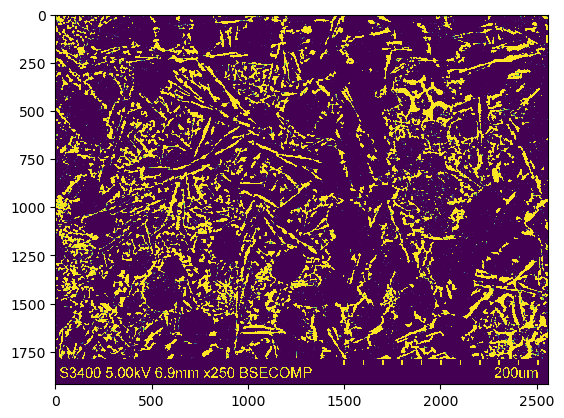

In [7]:
# preprocess with edge-preserving smoothing
ij.IJ.run(imp, "Kuwahara Filter", "sampling=10") # Look ma, a Fiji plugin!
ij.py.show(imp)

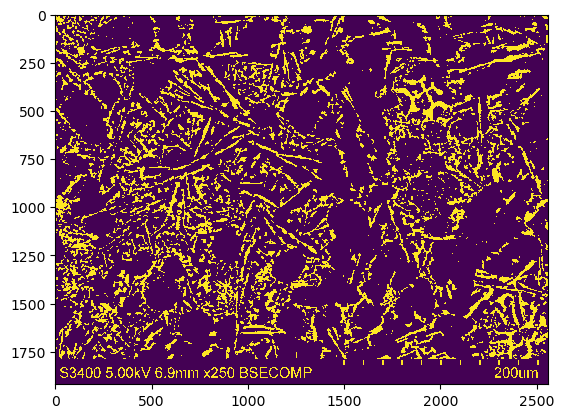

In [8]:
# threshold to binary mask
Prefs = sj.jimport('ij.Prefs')
Prefs.blackBackground = True
ij.IJ.setAutoThreshold(imp, "Otsu dark")
ImagePlus = sj.jimport("ij.ImagePlus")
mask = ImagePlus("cells-mask", imp.createThresholdMask())
ij.IJ.run(imp, "Close", "")
ij.py.show(mask)

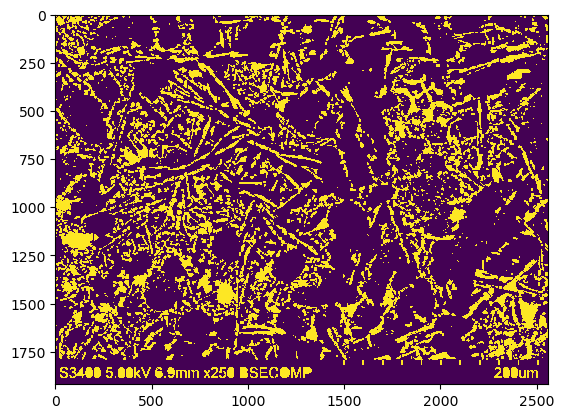

In [9]:
# clean up the binary mask.
ij.IJ.run(mask, "Dilate", "")
ij.IJ.run(mask, "Fill Holes", "")
ij.IJ.run(mask, "Watershed", "")
ij.py.show(mask)

In [10]:
# Save the mask as a selection (a.k.a. ROI).
ij.IJ.run(mask, "Create Selection", "")
roi = mask.getRoi()
ij.IJ.run(mask, "Close", "")

# Split the ROI into cells.
# This works because cells are disconnected due to the watershed.
rois = roi.getRois()
print(len(rois), "cells detected")

4305 cells detected


In [11]:
# Calculate statistics.

from collections import defaultdict
from pandas import DataFrame

# Make sure to measure the same slice as segmented!
#imp.setPosition(c, z, t)

# Measure each cell, accumulating results into a dictionary.
ij.IJ.run("Set Measurements...", "area mean min centroid median skewness kurtosis redirect=None decimal=3");
results = ij.ResultsTable.getResultsTable()
stats_ij = defaultdict(list)
for cell in rois:
    imp.setRoi(cell)
    ij.IJ.run(imp, "Measure", "")
    for column in results.getHeadings():
        stats_ij[column].append(results.getColumn(column)[-1])

Operating in headless mode - the ResultsTable class will not be fully functional.


In [12]:
# Display the results.
df_ij = DataFrame(stats_ij)
# pandas thinks the keys/col names are multi-level
# see pandas docs for more info: https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html
df_ij.columns = [''.join(col) for col in df_ij.columns.values]
df_ij

,Area,Mean,Min,Max,X,Y,Median,Skew,Kurt
0,0.000027,59.857143,20.0,194.0,0.460519,0.002651,41.0,1.926829,1.929939
1,0.000164,93.395349,0.0,254.0,0.573742,0.005700,51.0,0.688878,-1.215728
2,0.000462,151.950413,0.0,248.0,1.782582,0.005254,195.0,-0.676710,-1.024543
3,0.000179,141.765957,0.0,255.0,4.916701,0.006005,224.0,-0.295273,-1.843370
4,0.000301,191.215190,0.0,255.0,4.981124,0.006836,255.0,-1.186765,-0.516656
...,...,...,...,...,...,...,...,...,...
4300,0.000866,172.845815,0.0,255.0,2.245754,3.670898,245.0,-0.800440,-1.347857
4301,0.009796,96.596963,0.0,255.0,2.329094,3.633768,0.0,0.474144,-1.765158
4302,0.007191,116.592573,0.0,255.0,4.576141,3.634845,0.0,0.148966,-1.967167
4303,0.007191,116.592573,0.0,255.0,4.658173,3.634845,0.0,0.148966,-1.967167
